<a href="https://colab.research.google.com/github/AUT-Student/NN-HW8/blob/main/NN_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: Neural Network
<br>
<b>Description:</b> HomeWork 8
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

Source: https://www.tensorflow.org/text/tutorials/transformer

# Library

In [2]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 34.5 MB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 5.8 MB 55.5 MB/s 
     |████████████████████████████████| 438 kB 65.0 MB/s 
     |████████████████████████████████| 1.6 MB 54.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_text

from keras.layers import Dense, Input, Layer, Embedding, Dropout
from keras.layers import MultiHeadAttention, LayerNormalization
from keras.models import Sequential
import keras.backend as K

# Dataset

In [4]:
dataset = tfds.load('ted_hrlr_translate/pt_to_en', with_info=False, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete4ZDVR4/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete4ZDVR4/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete4ZDVR4/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]
valid_dataset = dataset["validation"]

# Tokenization

In [6]:
tokenizers_model_name = 'ted_hrlr_translate_pt_en_converter'
keras.utils.get_file(
    f'{tokenizers_model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{tokenizers_model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(tokenizers_model_name)
en_tokenizer = tokenizers.en
pt_tokenizer = tokenizers.pt

# Preprocessing

In [8]:
en_length_list = np.zeros(0)
pt_length_list = np.zeros(0)
for pt_data, en_data in train_dataset.batch(1024):
  new_en_length_list = en_tokenizer.tokenize(en_data).row_lengths().numpy()
  new_pt_length_list = pt_tokenizer.tokenize(pt_data).row_lengths().numpy()

  en_length_list = np.concatenate((en_length_list, new_en_length_list))
  pt_length_list = np.concatenate((pt_length_list, new_pt_length_list))

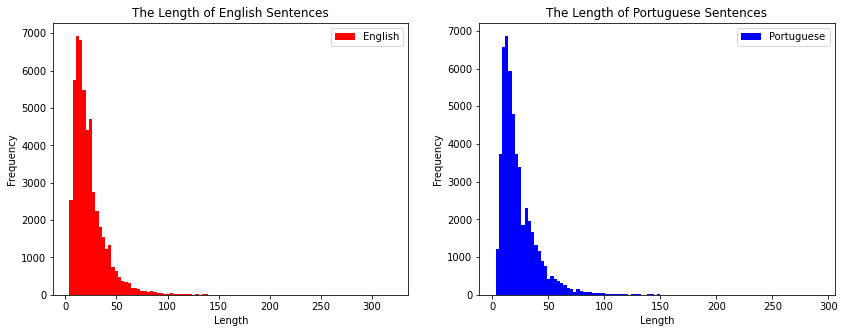

In [9]:
fig, ax = plt.subplots(1,2)

ax[0].hist(en_length_list, bins=100, color="red", label="English")
ax[1].hist(pt_length_list, bins=100, color="blue", label="Portuguese")
ax[0].legend()
ax[1].legend()
ax[0].set_title("The Length of English Sentences")
ax[1].set_title("The Length of Portuguese Sentences")
ax[0].set_xlabel("Length")
ax[1].set_xlabel("Length")
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")

fig.set_size_inches(14, 5)
plt.show()

In [10]:
MAX_LENGTH = 128

In [11]:
def is_size_good(pt, en):
  return tf.shape(pt)[1] < MAX_LENGTH and tf.shape(en)[1] < MAX_LENGTH

In [12]:
def tokenize(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return pt, en

In [13]:
def create_dataset_batches(dataset, batch_size):
  return dataset.batch(batch_size).map(tokenize, -1).filter(is_size_good).prefetch(-1)

In [14]:
batch_size = 64

train_dataset = create_dataset_batches(train_dataset, batch_size)

# Positional Encoding

In [15]:
def get_angles(position, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return position * angle_rates

In [16]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

# Masking

In [17]:
def create_padding_mask(sequence):
  sequence = tf.cast(tf.math.not_equal(sequence, 0), tf.float32)
  mask = sequence[:, tf.newaxis, tf.newaxis, :]
  return mask

In [18]:
def create_look_ahead_mask(size):
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

# Transformer FeedForward

In [19]:
class TransformerFeedForward(keras.Model):
  def __init__(self, d_feedforward, d_model):
    super().__init__()

    self.model = Sequential([
                             Dense(d_feedforward, activation="relu"),
                             Dense(d_model)

    ])
  
  def call(self, inputs):
    return self.model.call(inputs)

# Encoder Block

In [20]:
class EncoderBlock(Layer):
  def __init__(self, d_model, number_heads, d_feedforward):
    super().__init__()

    self.multi_head_attention = MultiHeadAttention(num_heads=number_heads, key_dim=d_model)
    self.feedforward = TransformerFeedForward(d_feedforward=d_feedforward, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)

    self.dropout_1 = Dropout(rate=0.1)
    self.dropout_2 = Dropout(rate=0.1)

  def call(self, x, mask, training):
    attention_output = self.multi_head_attention(x, x, x, mask)
    dropout_1_output = self.dropout_1(attention_output, training=training)
    normal_output = self.normal_1(dropout_1_output + x)

    feedforward_output = self.feedforward(normal_output)
    dropout_2_output = self.dropout_2(feedforward_output)
    output = self.normal_2(dropout_2_output + normal_output) 

    return output

# Decoder Block

In [21]:
class DecoderBlock(Layer):
  def __init__(self, number_heads, d_feedforward, d_model):
    super().__init__()
    self.multi_head_attention_1 = MultiHeadAttention(num_heads=number_heads, key_dim=d_model)
    self.multi_head_attention_2 = MultiHeadAttention(num_heads=number_heads, key_dim=d_model)
    
    self.feedforward = TransformerFeedForward(d_feedforward=d_feedforward, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)
    self.normal_3 = LayerNormalization(epsilon=1e-6)

    self.dropout_1 = Dropout(rate=0.1)
    self.dropout_2 = Dropout(rate=0.1)    
    self.dropout_3 = Dropout(rate=0.1)

  def call(self, x, encoder_output, look_ahead_mask, padding_mask, training):    
    attention_output_1, attention_weights_1 = self.multi_head_attention_1(
        x, x, x, look_ahead_mask, return_attention_scores=True)

    dropout_1_output = self.dropout_1(attention_output_1, training=training)
    normal_1_output = self.normal_1(dropout_1_output + x)

    attention_2_output, attention_weights_2 = self.multi_head_attention_2(
        key=encoder_output, value=encoder_output, query=normal_1_output, attention_mask=padding_mask, return_attention_scores=True)
    
    dropout_2_output = self.dropout_2(attention_2_output, training=training)
    normal_2_output = self.normal_2(dropout_2_output + normal_1_output)
    
    feedforward_output = self.feedforward(normal_2_output)
    dropout_3_output = self.dropout_3(feedforward_output, training=training)
    normal_3_output = self.normal_3(dropout_3_output + normal_2_output)

    return normal_3_output, attention_weights_1, attention_weights_2

# Encoder

In [22]:
class Encoder(Layer):
  def __init__(self, number_blocks, d_feedforward, d_model, source_vocab_size,
               number_heads):
    
    super().__init__()
    self.embedding = Embedding(source_vocab_size, d_model)
    self.number_blocks = number_blocks
    self.d_model = d_model

    self.pos_encoding = positional_encoding(MAX_LENGTH, self.d_model)
    self.dropout = Dropout(rate=0.1)

    self.encoder_blocks = []
    for _ in range(number_blocks):
      self.encoder_blocks.append(EncoderBlock(d_model=d_model, number_heads=number_heads, d_feedforward=d_feedforward))

  def call(self, x, mask, training):
    sequence_length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    x += self.pos_encoding[:, :sequence_length, :]
    x = self.dropout(x, training=training)

    for i in range(self.number_blocks):
      x = self.encoder_blocks[i](x, mask, training)

    return x 

# Decoder

In [23]:
class Decoder(Layer):
  def __init__(self, number_blocks, d_feedforward, d_model, number_heads,
               target_vocab_size):
    
    super().__init__()
    self.embedding = Embedding(target_vocab_size, d_model)
    self.number_blocks = number_blocks
    self.d_model = d_model

    self.pos_encoding = positional_encoding(MAX_LENGTH, d_model)
    self.dropout = Dropout(rate=0.1)

    self.decoder_blocks = []
    for _ in range(number_blocks):
      self.decoder_blocks.append(DecoderBlock(d_model=d_model,
                                              number_heads=number_heads,
                                              d_feedforward=d_feedforward))

  def call(self, x, encoder_output, look_ahead_mask, padding_mask, training):
    sequence_length = tf.shape(x)[1]
    attention_weights = []

    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

    x += self.pos_encoding[:, :sequence_length, :]
    x = self.dropout(x)

    for i in range(self.number_blocks):
      x, new_attention_weights_1, new_attention_weights_2 =\
       self.decoder_blocks[i](x=x, encoder_output=encoder_output,
                              look_ahead_mask=look_ahead_mask,
                              padding_mask=padding_mask, training=training)

      attention_weights.append({1:new_attention_weights_1,
                                2:new_attention_weights_2})

    return x, attention_weights      

# Transformer

In [24]:
class Transformer(keras.Model):
  def __init__(self, number_blocks, number_heads,
               d_feedforward, d_model, source_vocab_size,
               target_vocab_size):
    super().__init__()

    self.encoder = Encoder(number_blocks=number_blocks,
                           d_feedforward=d_feedforward, d_model=d_model,
                           source_vocab_size=source_vocab_size,
                           number_heads=number_heads)

    self.decoder = Decoder(number_blocks=number_blocks,
                           d_feedforward=d_feedforward, d_model=d_model,
                           target_vocab_size=target_vocab_size,
                           number_heads=number_heads)

    self.last_layer = Dense(target_vocab_size)

  def create_masks(self, pt_inputs, en_inputs):
    padding_mask = create_padding_mask(pt_inputs)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(en_inputs)[1])
    dec_target_padding_mask = create_padding_mask(en_inputs)
    look_ahead_mask = tf.minimum(dec_target_padding_mask, look_ahead_mask)
    
    return padding_mask, look_ahead_mask
  
  def call(self, inputs, training):
    pt_inputs, en_inputs = inputs

    padding_mask, look_ahead_mask = self.create_masks(pt_inputs, en_inputs)

    encoder_output = self.encoder(pt_inputs, padding_mask, training)

    decoder_output, attention_weights = self.decoder(x=en_inputs,
                                                     encoder_output=encoder_output,
                                                     look_ahead_mask=look_ahead_mask,
                                                     padding_mask=padding_mask, training=training)

    final_output = self.last_layer(decoder_output)

    return final_output, attention_weights

# Train

In [26]:
number_blocks = 4
d_model = 128
d_feedforward = 512
number_heads = 8
number_epochs = 20

In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [28]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [29]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [30]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [35]:
transformer = Transformer(number_blocks=number_blocks,
                          number_heads=number_heads,
                          d_feedforward=d_feedforward, d_model=d_model,
                          source_vocab_size=pt_tokenizer.get_vocab_size().numpy(),
                          target_vocab_size=en_tokenizer.get_vocab_size().numpy())

In [36]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(pt_inputs, en_inputs):

  en_inputs_input = en_inputs[:, :-1]
  en_inputs_real = en_inputs[:, 1:]

  with tf.GradientTape() as tape:
    predictions = transformer([pt_inputs, en_inputs_input], training=True)[0]
    loss = loss_function(en_inputs_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(en_inputs_real, predictions))

In [37]:
for epoch in range(number_epochs):

  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (pt_inputs, en_inputs)) in enumerate(train_dataset):
    train_step(pt_inputs, en_inputs)

    if batch % 100 == 0:
      accuracy_percent = train_accuracy.result().numpy()*100
      loss_result = train_loss.result().numpy()
      print(f"Epoch {epoch+1} Batch {batch} -> Loss = {loss_result:.2f}, Accuracy {round(accuracy_percent,2)}%")

Epoch 1 Batch 0 -> Loss = 8.87, Accuracy 0.0%
Epoch 1 Batch 100 -> Loss = 8.69, Accuracy 3.62%
Epoch 1 Batch 200 -> Loss = 8.43, Accuracy 5.76%
Epoch 1 Batch 300 -> Loss = 8.06, Accuracy 7.1%
Epoch 1 Batch 400 -> Loss = 7.67, Accuracy 8.22%
Epoch 1 Batch 500 -> Loss = 7.34, Accuracy 9.89%
Epoch 1 Batch 600 -> Loss = 7.07, Accuracy 11.44%
Epoch 1 Batch 700 -> Loss = 6.83, Accuracy 12.79%
Epoch 2 Batch 0 -> Loss = 5.27, Accuracy 22.75%
Epoch 2 Batch 100 -> Loss = 5.16, Accuracy 23.56%
Epoch 2 Batch 200 -> Loss = 5.09, Accuracy 24.4%
Epoch 2 Batch 300 -> Loss = 5.00, Accuracy 25.36%
Epoch 2 Batch 400 -> Loss = 4.93, Accuracy 26.19%
Epoch 2 Batch 500 -> Loss = 4.86, Accuracy 26.9%
Epoch 2 Batch 600 -> Loss = 4.79, Accuracy 27.58%
Epoch 2 Batch 700 -> Loss = 4.73, Accuracy 28.21%
Epoch 3 Batch 0 -> Loss = 4.25, Accuracy 35.33%
Epoch 3 Batch 100 -> Loss = 4.26, Accuracy 33.44%
Epoch 3 Batch 200 -> Loss = 4.23, Accuracy 33.8%
Epoch 3 Batch 300 -> Loss = 4.18, Accuracy 34.32%
Epoch 3 Batch 400

# Translator

In [38]:
class Translator(keras.Model):
  def __init__(self, transformer, en_tokenizer, pt_tokenizer):
    super().__init__()

    self.transformer = transformer
    self.en_tokenizer = en_tokenizer
    self.pt_tokenizer = pt_tokenizer

  def translate(self, pt_sentence):
    pt_tokens = self.pt_tokenizer.tokenize(tf.expand_dims(pt_sentence, axis=0)).to_tensor()

    start_token, end_token = self.en_tokenizer.tokenize([''])[0]
    start_token = start_token[tf.newaxis]
    end_token = end_token[tf.newaxis]

    en_tokens = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    en_tokens = en_tokens.write(0, start_token)

    for i in range(MAX_LENGTH):
      en_tokens_transpose = tf.transpose(en_tokens.stack())

      predictions, _ = self.transformer([pt_tokens, en_tokens_transpose], training=False)

      predictions = predictions[:, -1:, :]

      predicted_id = tf.argmax(predictions, axis=-1)

      en_tokens = en_tokens.write(i+1, predicted_id[0])

      if predicted_id == end_token:
        break

    en_tokens_transpose = tf.transpose(en_tokens.stack())

    en_sentence = en_tokenizer.detokenize(en_tokens_transpose)[0]

    attention_weights = self.transformer([pt_tokens, en_tokens_transpose[:,:-1]], training=False)[1]

    return en_sentence, attention_weights

In [39]:
translator = Translator(transformer=transformer,
                        en_tokenizer=en_tokenizer, pt_tokenizer=pt_tokenizer)

# Test Examples

In [50]:
for test_example in test_dataset.take(20):
  pt_sentence = test_example[0].numpy().decode("utf-8")
  en_sentence = test_example[1].numpy()
  en_predicted_sentence = translator.translate(pt_sentence)[0]

  print(f"Portuguese Input Sentence  = {pt_sentence}")
  print(f"English Real Sentence      = {en_sentence}")
  print(f"English Predicted Sentence = {en_predicted_sentence.numpy()}\n")

Portuguese Input Sentence  = depois , podem fazer-se e testar-se previsões .
English Real Sentence      = b'then , predictions can be made and tested .'
English Predicted Sentence = b'then you can make it and read yourself predictions .'

Portuguese Input Sentence  = forçou a parar múltiplos laboratórios que ofereciam testes brca .
English Real Sentence      = b'it had forced multiple labs that were offering brca testing to stop .'
English Predicted Sentence = b'it forced to stop multiple labs which managers to fight bruton .'

Portuguese Input Sentence  = as formigas são um exemplo clássico ; as operárias trabalham para as rainhas e vice-versa .
English Real Sentence      = b'ants are a classic example ; workers work for queens and queens work for workers .'
English Predicted Sentence = b'ants are an example : operating for the queens and vice versa .'

Portuguese Input Sentence  = uma em cada cem crianças no mundo nascem com uma doença cardíaca .
English Real Sentence      = b'one of

# Attention Weights

In [81]:
pt_sentence = "logo a seguir , encontrei outra foto minha"

en_sentence, attention_weight = translator.translate(tf.constant(pt_sentence))

print(f"Portuguese Input Sentence  = {pt_sentence}")
print(f"English Predicted Sentence = {en_sentence.numpy()}\n")

attention_weight_decoder_encoder = tf.squeeze(attention_weight[-1][2]).numpy()

attention_weight_decoder_encoder_list = []

for i in range(attention_weight_decoder_encoder.shape[0]):
  attention_weight_decoder_encoder_list.append(
      attention_weight_decoder_encoder[i])

attention_weight_decoder_self = tf.squeeze(attention_weight[-1][1]).numpy()

attention_weight_decoder_self_list = []

for i in range(attention_weight_decoder_self.shape[0]):
  attention_weight_decoder_self_list.append(
      attention_weight_decoder_self[i])
  
pt_tokens = pt_tokenizer.tokenize([pt_sentence]).numpy()[0]
pt_tokens = pt_tokenizer.lookup([pt_tokens]).numpy()[0]

en_tokens = en_tokenizer.tokenize([en_sentence]).numpy()[0]
en_tokens = en_tokenizer.lookup([en_tokens]).numpy()[0]

print(f"pt_tokens = {pt_tokens}")
print(f"len(pt_tokens) = {len(pt_tokens)}")
print(f"en_tokens = {en_tokens}")
print(f"len(en_tokens)={len(en_tokens)}")

Portuguese Input Sentence  = logo a seguir , encontrei outra foto minha
English Predicted Sentence = b'so next , i found another picture of my living photo .'

pt_tokens = [b'[START]' b'logo' b'a' b'seguir' b',' b'encontrei' b'outra' b'foto'
 b'minha' b'[END]']
len(pt_tokens) = 10
en_tokens = [b'[START]' b'so' b'next' b',' b'i' b'found' b'another' b'picture' b'of'
 b'my' b'living' b'photo' b'.' b'[END]']
len(en_tokens)=14


In [86]:
attention_weight_decoder_encoder_list[0].shape

(13, 10)

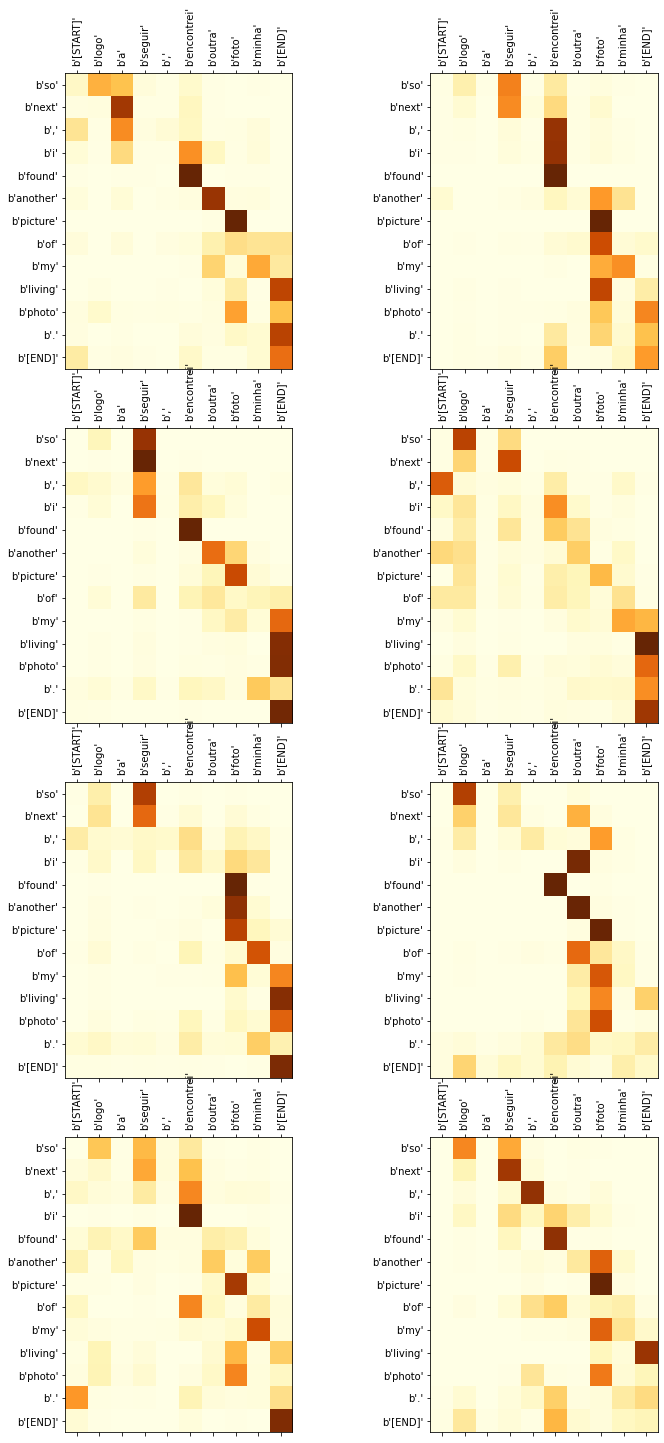

In [87]:
fig, ax = plt.subplots(4, 2)

for i in range(8):
  ax[i//2][i%2].matshow(attention_weight_decoder_encoder_list[i], cmap="YlOrBr")
  ax[i//2][i%2].set_xticks(range(len(pt_tokens)))
  ax[i//2][i%2].set_xticklabels(pt_tokens, rotation=90)

  ax[i//2][i%2].set_yticks(range(len(en_tokens[1:])))
  ax[i//2][i%2].set_yticklabels(en_tokens[1:])

fig.set_size_inches((12, 25))
plt.show()

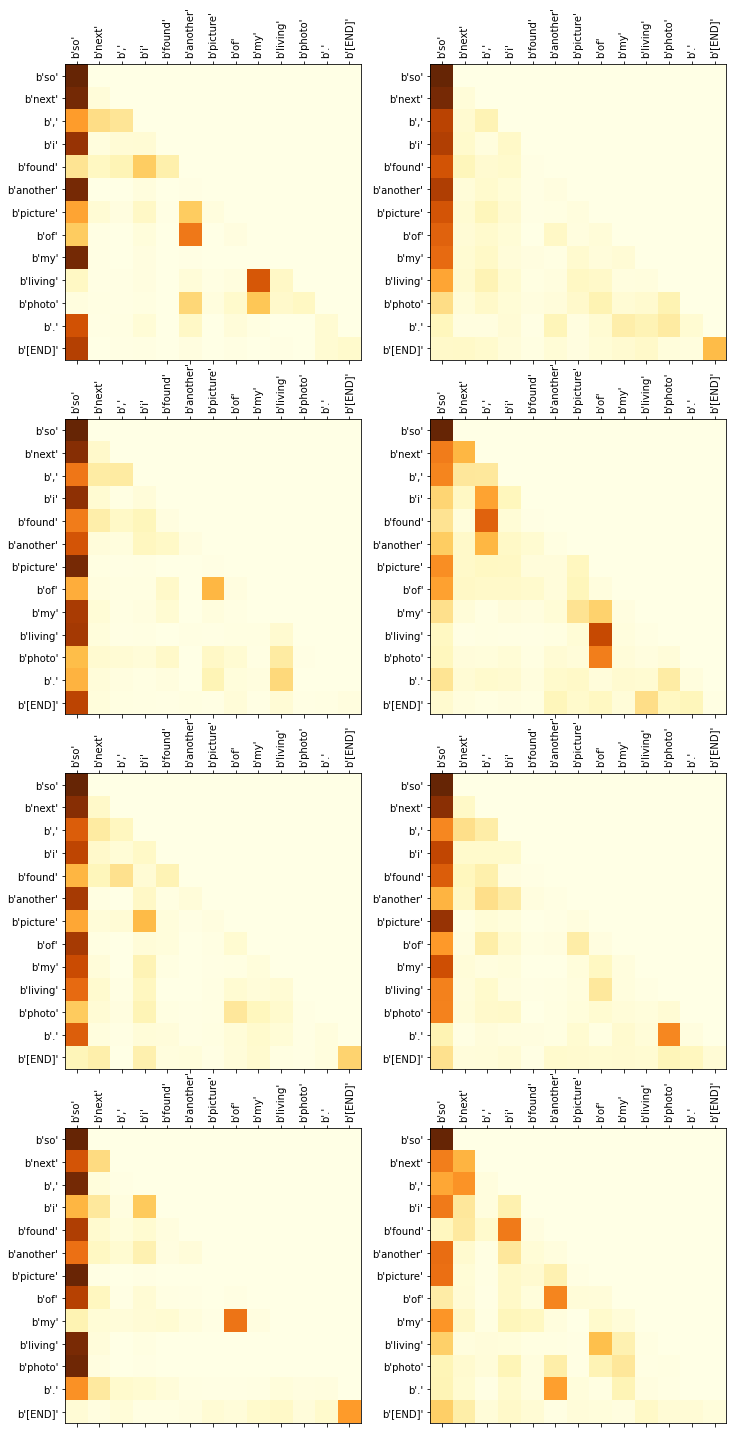

In [89]:
fig, ax = plt.subplots(4, 2)

for i in range(8):
  ax[i//2][i%2].matshow(attention_weight_decoder_self_list[i], cmap="YlOrBr")
  ax[i//2][i%2].set_xticks(range(len(en_tokens[1:])))
  ax[i//2][i%2].set_xticklabels(en_tokens[1:], rotation=90)

  ax[i//2][i%2].set_yticks(range(len(en_tokens[1:])))
  ax[i//2][i%2].set_yticklabels(en_tokens[1:])

fig.set_size_inches((12, 25))
plt.show()